# Figure S07. Physical overlaps of susceptibility-associated intervals

across toxicants

In [ ]:

library(dplyr)



Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last


Attaching package: 'kableExtra'

The following object is masked from 'package:dplyr':

    group_rows


Attaching package: 'flextable'

The following objects are masked from 'package:kableExtra':

    as_image, footnote

here() starts at /Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript

$strain_table
$strain_table$html
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S1/table_S1.html"

$strain_table$tsv
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S1/table_S1.tsv.zip"

$strain_table$docx
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S1/table_S1.docx"

$strain_table$csv
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S1/table_S1.csv"


$tox_table_ft
$tox_table_ft$html
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S2/table_S2.html"

$tox_table_ft$tsv
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S2/table_S2.tsv.zip"

$tox_table_ft$docx
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S2/table_S2.docx"

$tox_table_ft$csv
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S2/table_S2.csv"


$trait_table
$trait_table$html
[1] "/Users/ryanmckeown/Desktop/ToxinGWAS_Manuscript/tables/table_S3/table_S3.html"

$trait_table$tsv
[1] "

# Inputs

In [ ]:

### Load the Inbred intervals
ns_dir <- "data/processed/20231116_Analysis_NemaScan"

# toxicant condition metadata
tox_meta_fn <- "data/processed/tox_data/con_metadata.csv"

# load the inbred qtl overlaps with use group data
inbred_qtl_overlaps <- data.table::fread(
  "data/processed/interval_overlap/inbred_qtl_overlaps.csv"
)


# Main

In [ ]:
inbred_qtl <- data.table::fread(
  glue::glue("{ns_dir}/INBRED/Mapping/Processed/QTL_peaks_inbred.tsv")
) %>%
  # remove the CV_length traits
  dplyr::filter(!stringr::str_detect(trait, pattern = "CV_length"))


# Load the tox condition metadata
tox_metadata <- data.table::fread(tox_meta_fn) %>%
  dplyr::select(trait, nice_drug_label2, big_class, class, moa_class) %>%
  # adjust the uM to µM
  dplyr::mutate(nice_drug_label2 = dplyr::case_when(
    nice_drug_label2 == "uM" ~ "µM",
    TRUE ~ nice_drug_label2
  ))

  tox.QTL.summary <- inbred_qtl %>%
  dplyr::left_join(tox_metadata, by = c("trait" = "trait"))

#### Summarize the number of overlaps each interval has #### ----

# reduce column data to just the overlapping intervals before summarizing
overlapping_int_pairs <- inbred_qtl_overlaps %>%
  dplyr::filter(!is.na(peakidA) | !is.na(peakidB)) %>%
  dplyr::filter(peakidA != "" | peakidB != "") %>%
  dplyr::select(
    traitA,
    peakidA,
    traitB,
    peakidB
  )

# get the number of overlapping interval pairs
n_int_overlap_pairs <- overlapping_int_pairs %>%
  nrow()

# pivot the data to get the number of overlaps each interval has
overlaps_per_int_df <- overlapping_int_pairs %>%
  tidyr::pivot_longer(
    cols = c(peakidA, peakidB),
    names_to = "interval_col",
    values_to = "interval"
  ) %>%
  tidyr::pivot_longer(
    cols = c(traitA, traitB),
    names_to = "trait_col",
    values_to = "trait"
  ) %>%
  # remove rows where the trait and interval are the same
  dplyr::filter(
    interval_col == "peakidA" & trait_col == "traitA" |
      interval_col == "peakidB" & trait_col == "traitB"
  ) %>%
  # group by interval and trait and count
  count(interval, trait, name = "num_overlaps")

# Join the class data to the overlaps per interval data for plotting
class_key <- tox.QTL.summary %>%
  dplyr::select(
    marker,
    trait,
    big_class
  ) %>%
  dplyr::distinct()

overlaps_per_int_hist_df <- overlaps_per_int_df %>%
  dplyr::left_join(
    class_key,
    by = c("interval" = "marker", "trait")
  )

# create color palette for the big_class
man_pal <- tibble::tibble(
  col = c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#D55E00"),
  big_class = c("Control", "Flame Retardant", "Fungicide", "Herbicide", "Insecticide", "Metal")
) %>%
  dplyr::filter(big_class != "Control")

# get the size of the intervals
int_size_key <- tox.QTL.summary %>%
  dplyr::select(
    marker,
    trait,
    big_class,
    startPOS,
    endPOS
  ) %>%
  # calculate the size of the interval in Kb
  dplyr::mutate(
    int_size = (endPOS - startPOS) / 1000
  )

# join the interval size data to the overlaps per interval data
overlaps_per_int_size_df <- overlaps_per_int_df %>%
  dplyr::left_join(
    int_size_key,
    by = c("interval" = "marker", "trait")
  )


## Plot distribution of overlaps per interval

In [ ]:
## Plot distribution of overlaps per interval ##
n_overlaps_per_int_hist <- overlaps_per_int_hist_df %>%
  ggplot2::ggplot(
    aes(
      x = num_overlaps,
      fill = big_class
    )
  ) +
  geom_histogram(
    binwidth = 1
  ) +
  scale_fill_manual(values = man_pal$col) +
  labs(
    x = "Overlaps with other regions",
    y = "Number of regions"
  ) +
  theme_bw() +
  theme(
    panel.grid = ggplot2::element_blank(),
    legend.position = c(0.90, 0.80),
    legend.title = ggplot2::element_blank()
  )


3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.

## Interval size vs. number of overlaps

Calculate the linear model

In [ ]:
# calculate the linear model and extract the p-value
lm_model <- lm(num_overlaps ~ int_size, data = overlaps_per_int_size_df)
lm_summary <- broom::glance(lm_model)
p_value <- lm_summary$p.value

lm_summary


# A tibble: 1 × 12
  r.squared adj.r.squared sigma statistic p.value    df logLik   AIC   BIC
      <dbl>         <dbl> <dbl>     <dbl>   <dbl> <dbl>  <dbl> <dbl> <dbl>
1    0.0787        0.0419 0.946      2.14   0.156     1  -35.8  77.6  81.4
# ℹ 3 more variables: deviance <dbl>, df.residual <int>, nobs <int>

Plot interval size vs. number of overlaps

In [ ]:
# plot the number of overlaps compared to the size of the interval
n_overlaps_per_int_size <- overlaps_per_int_size_df %>%
  ggplot(
    aes(
      x = int_size,
      y = num_overlaps
    )
  ) +
  geom_point(
    aes(color = big_class)
  ) +
  # add regression line
  geom_smooth(
    method = "lm",
    se = FALSE
  ) +
  scale_color_manual(values = man_pal$col) +
  labs(
    x = "Region size (Kb)",
    y = "Number of overlaps"
  ) +
  theme_bw() +
  theme(
    panel.grid = ggplot2::element_blank(),
    legend.position = "top",
    legend.title = ggplot2::element_blank()
  ) +
  # add p-value annotation
  annotate(
    "text",
    x = 7500,
    y = 2.75,
    label = bquote(italic(p) == .(format(p_value, digits = 3))),
    hjust = 0
  ) +
  # add r-squared annotation
  annotate(
    "text",
    x = 7500,
    y = 3.0,
    label = bquote(R^2 == .(format(summary(lm_model)$r.squared, digits = 3))),
    hjust = 0
  )


# Combine plots

`geom_smooth()` using formula = 'y ~ x'

Warning in is.na(x): is.na() applied to non-(list or vector) of type 'language'
Warning in is.na(x): is.na() applied to non-(list or vector) of type 'language'

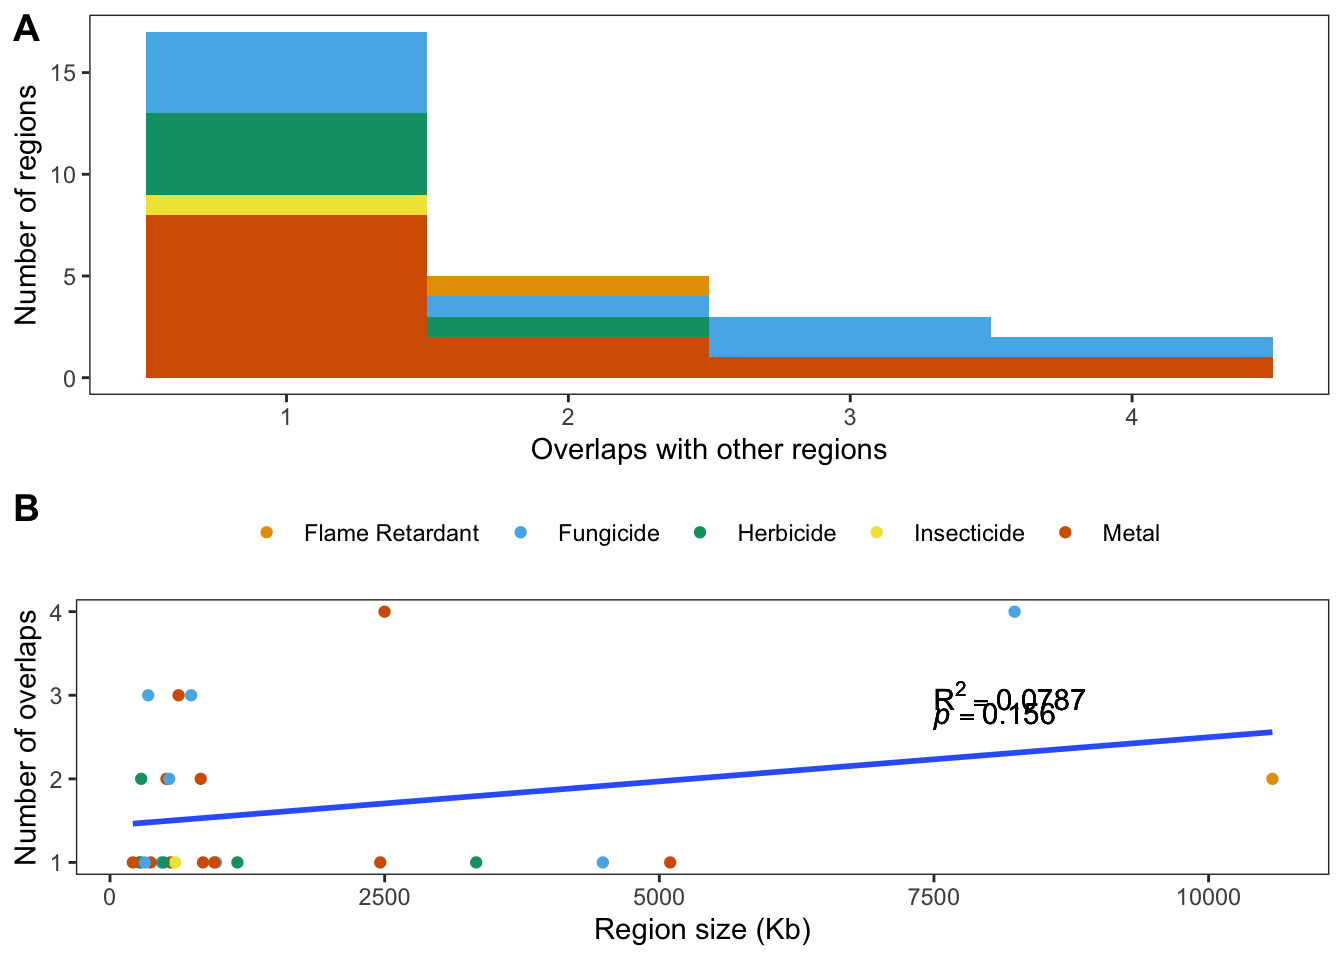

In [ ]:
#### Combine N overlaps per interval and N overlaps per interval size plots #### ----
overlaps_supp_fig <- cowplot::plot_grid(
  n_overlaps_per_int_hist
  + theme(legend.position = "none"),
  n_overlaps_per_int_size,
  ncol = 1,
  label_fontface = "bold",
  labels = c("A", "B")
)


In [ ]:
save_plot(
  overlaps_supp_fig,
  sup_figure_fns$physical_overlaps,
  w_in = 6.5, h_in = 6.5
)
